In [ ]:
import sys
# !{sys.executable} -m pip install tldextract

<div style='text-align:center;'>
<h1>BioPortal</h1>
</div>

In [66]:
__author__ = "Lisette Espin-Noboa"
__copyright__ = "Copyright 2018, HopRank"
__credits__ = ["Florian Lemmerich", "Markus Strohmaier", "Simon Walk", "Mark Musen"]
__license__ = "GPL"
__version__ = "1.0.3"
__maintainer__ = "Lisette Espin-Noboa"
__email__ = "Lisette.Espin@gesis.org"
__status__ = "Developing"

########################################################################################
# Warnings
########################################################################################
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

<h2>Dependencies</h2>

In [70]:
########################################################################################
# System
########################################################################################
import os
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from collections import Counter
from joblib import Parallel, delayed
import matplotlib as mpl
import matplotlib.pyplot as plt 


########################################################################################
# Local Dependencies
########################################################################################
%reload_ext autoreload
%autoreload 2
from org.gesis.libs.bioportal.ontology import Ontology
from org.gesis.libs.bioportal.transition import Transition
from org.gesis.libs.bioportal.clickstream import NAVITYPES
from org.gesis.libs.bioportal.clickstream import load_clickstream
from org.gesis.libs.bioportal.clickstream import preprocess_clickstream
from org.gesis.libs.bioportal.clickstream import preprocess_sessions
from org.gesis.libs.bioportal.clickstream import clean_clickstream
from org.gesis.libs.bioportal.submission import get_submissions
from org.gesis.libs.utils import log
from org.gesis.libs.utils import weighted_to_undirected


<h2>Constants</h2>

In [3]:
SM = 'submission'
SUBMISSIONS_FN = '/bigdata/lespin/datasets/bioportal/submissions.json'

ON = 'ontology'
ONTOLOGY_ROOT = '/bigdata/lespin/datasets/bioportal/ontologies'
ONTOLOGY_GRAPH_OUTPUT = '/bigdata/lespin/bioportal/ontologies/graph'
ONTOLOGY_ADJACENCY_OUTPUT = '/bigdata/lespin/bioportal/ontologies/matrix'
ONTOLOGY_NODES_OUTPUT = '/bigdata/lespin/bioportal/ontologies/nodes'

CS = 'clickstream'
CS_FN = 'BP_webpage_requests_<YEAR><POSTFIX>.csv.bz2'
CLICKSTREAM_ROOT = '/bigdata/lespin/datasets/bioportal/clickstream/'
CLICKSTREAM_DF = '/bigdata/lespin/bioportal/clickstreams'

TR = 'transitions'
TRANS_GRAPH_OUTPUT = '/bigdata/lespin/bioportal/transitions/graph'
TRANS_ADJACENCY_OUTPUT = '/bigdata/lespin/bioportal/transitions/matrix'
TRANS_NODES_OUTPUT = '/bigdata/lespin/bioportal/transitions/nodes'

LOG_OUTPUT = '/bigdata/lespin/bioportal/logs'
YEAR = '2015'

<div style='text-align:center;'>
<h1>Submissions</h1>
</div>

In [4]:
%%capture cap --no-stderr
submissions_dict = get_submissions(SUBMISSIONS_FN)

In [5]:
print(cap.stdout)
log(LOG_OUTPUT, SM, cap)
del(cap)

2018-11-11 23:48:47	/bigdata/lespin/datasets/bioportal/submissions.json loaded!
2018-11-11 23:48:47	- 642 ontologies
2018-11-11 23:48:47	- 13 years

2018-11-11 23:48:47	/bigdata/lespin/bioportal/logs/submission_2018-11-11_23.log saved!


<div style='text-align:center;'>
<h1>Clickstreams</h1>
</div>

<h2>1. Loading Clickstream (raw)</h2>

In [6]:
%%capture cap --no-stderr
clickstreams = load_clickstream(CLICKSTREAM_ROOT, YEAR)

In [7]:
print(cap.stdout)
log(LOG_OUTPUT, CS, cap)
del(cap)

2018-11-11 23:51:00	/bigdata/lespin/datasets/bioportal/clickstream/BP_webpage_requests_2015.csv.bz2 loaded!

2018-11-11 23:51:01	/bigdata/lespin/bioportal/logs/clickstream_2018-11-11_23.log saved!


In [8]:
clickstreams.head()

,Unnamed: 0,timestamp,req_id,ip,action,request,request_action,statuscode,size,referer,useragent,ontology,concept
0,0,2015-01-01 00:00:23,26123018,155.94.218.175,GET,/ontologies/ICD9CM/classes/176,Browse Ontology Class,301.0,142.0,http://purl.bioontology.org/,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,ICD9CM,NaN
1,1,2015-01-01 00:00:24,26123019,155.94.218.175,GET,/ontologies/ICD9CM?p=classes&conceptid=176,Browse Ontology Class,500.0,2073.0,http://purl.bioontology.org/,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,ICD9CM,176
2,2,2015-01-01 00:00:27,26123020,155.94.218.175,GET,/help,Browse Help,200.0,8644.0,http://bioportal.bioontology.org/ontologies/IC...,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,NAN,NaN
3,3,2015-01-01 00:01:18,35315115,50.18.157.78,GET,/ontologies/1341?apikey=25503fcd-f8e2-4f3f-90e...,Ontology Summary,301.0,157.0,http://localhost:4444/selenium-server/core/Bla...,Mozilla/5.0 (X11; Linux i686; rv:10.0) Gecko/2...,1341,NaN
4,4,2015-01-01 00:01:18,35315116,50.18.157.78,GET,/ontologies/COSTART?apikey=25503fcd-f8e2-4f3f-...,Ontology Summary,200.0,6257.0,http://localhost:4444/selenium-server/core/Bla...,Mozilla/5.0 (X11; Linux i686; rv:10.0) Gecko/2...,COSTART,NaN


<h2>2. Pre-processing Clickstream</h2>
<h3>2.1. Parsing: inferring ontology/concept/navitype</h3>

In [9]:
%%capture cap --no-stderr
clickstreams = preprocess_clickstream(clickstreams)

In [10]:
print(cap.stdout)
log(LOG_OUTPUT, CS, cap)
del(cap)


2018-11-12 00:14:32	/bigdata/lespin/bioportal/logs/clickstream_2018-11-12_00.log saved!


In [11]:
clickstreams.head()

,Unnamed: 0,timestamp,req_id,ip,action,request,request_action,statuscode,size,referer,useragent,ontology,concept,_ontology,_concept,_navitype,_request
0,0,2015-01-01 00:00:23,26123018,155.94.218.175,GET,/ontologies/ICD9CM/classes/176,Browse Ontology Class,301.0,142.0,http://purl.bioontology.org/,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,ICD9CM,NaN,ICD9CMCLASSES176,NaN,O,/ontologies/ICD9CM/classes/176
1,1,2015-01-01 00:00:24,26123019,155.94.218.175,GET,/ontologies/ICD9CM?p=classes&conceptid=176,Browse Ontology Class,500.0,2073.0,http://purl.bioontology.org/,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,ICD9CM,176,ICD9CM,176,EL,/ontologies/ICD9CM?p=classes&conceptid=176
2,2,2015-01-01 00:00:27,26123020,155.94.218.175,GET,/help,Browse Help,200.0,8644.0,http://bioportal.bioontology.org/ontologies/IC...,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,NAN,NaN,HELP,NaN,O,/help
3,3,2015-01-01 00:01:18,35315115,50.18.157.78,GET,/ontologies/1341?apikey=25503fcd-f8e2-4f3f-90e...,Ontology Summary,301.0,157.0,http://localhost:4444/selenium-server/core/Bla...,Mozilla/5.0 (X11; Linux i686; rv:10.0) Gecko/2...,1341,NaN,1341,NaN,O,/ontologies/1341?apikey=25503fcd-f8e2-4f3f-90e...
4,4,2015-01-01 00:01:18,35315116,50.18.157.78,GET,/ontologies/COSTART?apikey=25503fcd-f8e2-4f3f-...,Ontology Summary,200.0,6257.0,http://localhost:4444/selenium-server/core/Bla...,Mozilla/5.0 (X11; Linux i686; rv:10.0) Gecko/2...,COSTART,NaN,COSTART,NaN,O,/ontologies/COSTART?apikey=25503fcd-f8e2-4f3f-...


In [12]:
fn = CS_FN.replace('<YEAR>',YEAR).replace('<POSTFIX>','_parsed')
fn = os.path.join(CLICKSTREAM_DF,fn)
clickstreams.to_csv(fn, compression='bz2')

<h3>2.2. Assigning Sessions</h3>

In [13]:
%%capture cap --no-stderr
clickstreams = preprocess_sessions(clickstreams)

In [14]:
print(cap.stdout)
log(LOG_OUTPUT, CS, cap)
del(cap)


2018-11-12 00:27:32	/bigdata/lespin/bioportal/logs/clickstream_2018-11-12_00.log saved!


In [15]:
clickstreams.head()

,Unnamed: 0,timestamp,req_id,ip,action,request,request_action,statuscode,size,referer,useragent,ontology,concept,_ontology,_concept,_navitype,_request,_sessionid,_year
3541980,3541980,2015-07-08 08:31:17,20296651,1.0.136.11,GET,/ontologies/SNOMEDCT/classes/113298000,Browse Ontology Class,301.0,151.0,-,Mozilla/5.0 (iPad; CPU OS 8_1_2 like Mac OS X)...,SNOMEDCT,NaN,SNOMEDCTCLASSES113298000,NaN,O,/ontologies/SNOMEDCT/classes/113298000,1,2015
3541983,3541983,2015-07-08 08:31:18,20296652,1.0.136.11,GET,/ontologies/SNOMEDCT?p=classes&conceptid=11329...,Browse Ontology Class,200.0,7814.0,-,Mozilla/5.0 (iPad; CPU OS 8_1_2 like Mac OS X)...,SNOMEDCT,113298000,SNOMEDCT,113298000,DU,/ontologies/SNOMEDCT?p=classes&conceptid=11329...,1,2015
4067058,4067058,2015-12-30 08:41:59,20296663,1.0.184.237,GET,/ontologies/RCD,Ontology Summary,200.0,9083.0,http://bioportal.bioontology.org/,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,RCD,NaN,RCD,NaN,O,/ontologies/RCD,2,2015
4035152,4035152,2015-12-23 08:16:49,20296664,1.0.186.30,GET,/resource_index,Browse Resource Index,200.0,558983.0,http://bioportal.bioontology.org/,Mozilla/5.0 (Windows NT 6.1; rv:34.0) Gecko/20...,NAN,NaN,RESOURCE_INDEX,NaN,O,/resource_index,3,2015
3974831,3974831,2015-12-18 09:50:46,20296665,1.0.187.201,GET,/projects/sparepart,Browse Project,200.0,4472.0,http://bioportal.bioontology.org/,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...,NAN,NaN,PROJECTSSPAREPART,NaN,O,/projects/sparepart,4,2015


In [16]:
fn = CS_FN.replace('<YEAR>',YEAR).replace('<POSTFIX>','_parsed_sessions')
fn = os.path.join(CLICKSTREAM_DF,fn)
clickstreams.to_csv(fn, compression='bz2')

<h3>2.3. Extracting only valid Requests (and setting sequence within session)</h3>
<ul>
<li>Valid HTTP request: statuscode=200</li>
<li>Valid Navitype: DC, DE, EX, LS, DU, EL, ES</li>
<li>Request to a non-empty ontology and non-empty concept</li>
</ul>

In [17]:
%%capture cap --no-stderr
valid_clickstreams = clean_clickstream(clickstreams)

In [18]:
print(cap.stdout)
log(LOG_OUTPUT, CS, cap)
del(cap)


2018-11-12 00:42:06	/bigdata/lespin/bioportal/logs/clickstream_2018-11-12_00.log saved!


In [19]:
valid_clickstreams.head()

,original_id,timestamp,req_id,ip,action,request,request_action,statuscode,size,referer,useragent,ontology,concept,_ontology,_concept,_navitype,_request,_sessionid,_year,_sequence
0,3541983,2015-07-08 08:31:18,20296652,1.0.136.11,GET,/ontologies/SNOMEDCT?p=classes&conceptid=11329...,Browse Ontology Class,200.0,7814.0,-,Mozilla/5.0 (iPad; CPU OS 8_1_2 like Mac OS X)...,SNOMEDCT,113298000,SNOMEDCT,113298000,DU,/ontologies/SNOMEDCT?p=classes&conceptid=11329...,1,2015,1
1,1049578,2015-02-24 08:49:06,20296672,1.0.206.131,GET,/ajax_concepts/CPT/?conceptid=http%3A%2F%2Fpur...,Browse Ontology Class,200.0,2297.0,http://bioportal.bioontology.org/ontologies/CP...,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,CPT,http://purl.bioontology.org/ontology/CPT/1005780,CPT,1005780,DC,/ajax_concepts/CPT/?conceptid=http://purl.bioo...,8,2015,2
2,1049579,2015-02-24 08:49:11,20296680,1.0.206.131,GET,/ajax_concepts/CPT/?conceptid=http%3A%2F%2Fpur...,Browse Ontology Class Tree,200.0,268.0,http://bioportal.bioontology.org/ontologies/CP...,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,CPT,http://purl.bioontology.org/ontology/CPT/1005780,CPT,1005780,EX,/ajax_concepts/CPT/?conceptid=http://purl.bioo...,8,2015,3
3,1049585,2015-02-24 08:49:19,20296681,1.0.206.131,GET,/ajax_concepts/CPT/?conceptid=http%3A%2F%2Fpur...,Browse Ontology Class,200.0,2634.0,http://bioportal.bioontology.org/ontologies/CP...,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,CPT,http://purl.bioontology.org/ontology/CPT/1005781,CPT,1005781,DC,/ajax_concepts/CPT/?conceptid=http://purl.bioo...,8,2015,4
4,1049586,2015-02-24 08:49:25,20296695,1.0.206.131,GET,/ajax_concepts/CPT/?conceptid=http%3A%2F%2Fpur...,Browse Ontology Class Tree,200.0,220.0,http://bioportal.bioontology.org/ontologies/CP...,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,CPT,http://purl.bioontology.org/ontology/CPT/1005781,CPT,1005781,EX,/ajax_concepts/CPT/?conceptid=http://purl.bioo...,8,2015,5


In [20]:
fn = CS_FN.replace('<YEAR>',YEAR).replace('<POSTFIX>','_parsed_sessions_prevalid')
fn = os.path.join(CLICKSTREAM_DF,fn)
valid_clickstreams.to_csv(fn, compression='bz2')

<h3>2.4. Summaries</h3>

In [21]:
valid_clickstreams.sample(5)

,original_id,timestamp,req_id,ip,action,request,request_action,statuscode,size,referer,useragent,ontology,concept,_ontology,_concept,_navitype,_request,_sessionid,_year,_sequence
1000132,1354488,2015-03-09 08:24:53,36975057,65.49.68.155,GET,/ajax_concepts/NBO/?conceptid=http%3A%2F%2Fpur...,Browse Ontology Class Tree,200.0,483.0,http://bioportal.bioontology.org/ontologies/NB...,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,NBO,http://purl.obolibrary.org/obo/GO_0043523,NBO,go_0043523,EX,/ajax_concepts/NBO/?conceptid=http://purl.obol...,431036,2015,1000133
866640,2868800,2015-06-01 06:58:25,35604908,50.18.157.78,GET,/ontologies/NCIT?p=classes&conceptid=C3224&api...,Browse Ontology Class,200.0,10287.0,http://localhost:4444/selenium-server/core/Bla...,Mozilla/5.0 (X11; Linux i686; rv:10.0) Gecko/2...,NCIT,C3224,NCIT,c3224,EL,/ontologies/NCIT?p=classes&conceptid=C3224&api...,390790,2015,866641
395227,2097533,2015-04-16 00:33:02,28839037,176.10.104.227,GET,/ontologies/DRON?p=classes&conceptid=http%3A%2...,Browse Ontology Class,200.0,27566.0,-,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,DRON,http://purl.obolibrary.org/obo/DRON_00074640,DRON,dron_00074640,DU,/ontologies/DRON?p=classes&conceptid=http://pu...,183018,2015,395228
411621,174121,2015-01-12 14:12:35,29093157,179.7.114.46,GET,/ontologies/VANDF?p=classes&conceptid=http%3A%...,Browse Ontology Class,200.0,10105.0,https://www.google.com.pe/,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,VANDF,http://purl.bioontology.org/ontology/VANDF/402...,VANDF,4024662,ES,/ontologies/VANDF?p=classes&conceptid=http://p...,189809,2015,411622
1237927,3525993,2015-07-07 05:16:06,39508294,75.118.25.249,GET,/ontologies/CPT?p=classes&conceptid=87220,Browse Ontology Class,200.0,7981.0,https://www.google.com/,Mozilla/5.0 (Linux; Android 4.4.4; SGH-M919 Bu...,CPT,87220,CPT,87220,ES,/ontologies/CPT?p=classes&conceptid=87220,508010,2015,1237928


In [22]:
%%capture cap --no-stderr
print('{} total records in clickstream {}'.format(len(clickstreams),YEAR))
print('- {} ({}%) pre-valid records'.format(len(valid_clickstreams),round(len(valid_clickstreams)*100/len(clickstreams))))
print('- {} sessions'.format(valid_clickstreams._sessionid.nunique()))
print('- {} ontologies'.format(valid_clickstreams._ontology.nunique()))

In [23]:
print(cap.stdout)
log(LOG_OUTPUT, CS, cap)
del(cap)

4075563 total records in clickstream 2015
- 1345655 (33%) pre-valid records
- 397262 sessions
- 598 ontologies

2018-11-12 00:48:00	/bigdata/lespin/bioportal/logs/clickstream_2018-11-12_00.log saved!


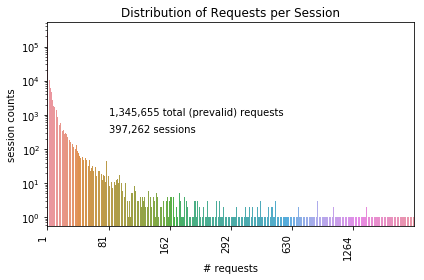

In [24]:
nrequestspersession = pd.DataFrame({'nrequests':valid_clickstreams.groupby(['_sessionid']).size().values})
ax = sns.countplot(x='nrequests',data=nrequestspersession)
ax.set_yscale('log')
step=80
xt = ax.get_xticks()[::step]
xl = [t.get_text() for t in ax.get_xticklabels()[::step]]
_ = ax.set_xticks(xt)
_ = ax.set_xticklabels(xl, rotation=90, ha='right')
ax.set_title('Distribution of Requests per Session')
try:
    ax.text(xt[1], 1000, '{:,} total (prevalid) requests'.format(len(valid_clickstreams)))
    ax.text(xt[1], 300, '{:,} sessions'.format(valid_clickstreams._sessionid.nunique()))
except:
    pass
_ = ax.set_ylabel('session counts')
_ = ax.set_xlabel('# requests')
plt.tight_layout()

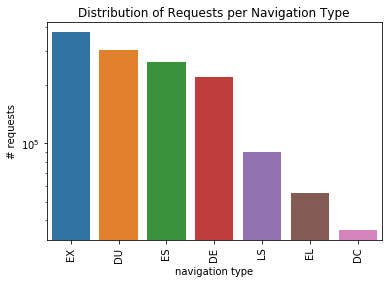

In [25]:
ax = sns.countplot(x='_navitype',
                   data=valid_clickstreams,
                   order=valid_clickstreams['_navitype'].value_counts().index)
ax.set_yscale('log')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Distribution of Requests per Navigation Type')
_ = ax.set_ylabel('# requests')
_ = ax.set_xlabel('navigation type')

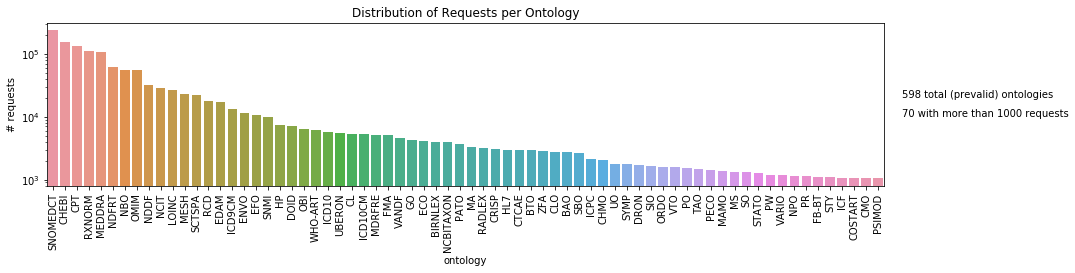

In [26]:
minreq = 1000
valid_ontologies_clickstream = valid_clickstreams.groupby('_ontology')
valid_ontologies_clickstream = valid_ontologies_clickstream.filter(lambda x: len(x) > minreq)

fig,ax = plt.subplots(1,1,figsize=(15,3))
_ = sns.countplot(x='_ontology',data=valid_ontologies_clickstream,ax=ax,
                  order=valid_ontologies_clickstream['_ontology'].value_counts().index)
ax.set_yscale('log')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Distribution of Requests per Ontology')
_ = ax.set_ylabel('# requests')
_ = ax.set_xlabel('ontology')
try:
    nonto = valid_ontologies_clickstream._ontology.nunique()
    ax.text(nonto+1, 20000, '{} total (prevalid) ontologies'.format(valid_clickstreams._ontology.nunique()))
    ax.text(nonto+1, 10000, '{} with more than {} requests'.format(nonto,minreq))
except:
    pass

<div style='text-align:center;'>
<h1>Ontologies</h1>
</div>

In [27]:
%%capture cap --no-stderr
onto_name = 'CPT'
submission = submissions_dict[onto_name][YEAR]
onto = Ontology(name=onto_name, year=YEAR, submission_id=submission['submissionId'], root_folder=ONTOLOGY_ROOT)
onto.load_ontology()
onto.create_adjacency_matrix()
onto.save_graph(path=ONTOLOGY_GRAPH_OUTPUT)
onto.save_adjacency(path=ONTOLOGY_ADJACENCY_OUTPUT)
onto.save_nodes(path=ONTOLOGY_NODES_OUTPUT)

In [28]:
print(cap.stdout)
log(LOG_OUTPUT, ON, cap)
del(cap)

2018-11-12 00:48:18	/bigdata/lespin/datasets/bioportal/ontologies/CPT/6/CPT.csv.gz loaded!
2018-11-12 00:48:22	Convertion CPT-2015 DataFrame to DiGraph done!
2018-11-12 00:48:22	/bigdata/lespin/bioportal/ontologies/graph/CPT_2015.gpickle saved!
2018-11-12 00:48:22	/bigdata/lespin/bioportal/ontologies/matrix/CPT_2015.mtx saved!
2018-11-12 00:48:22	/bigdata/lespin/bioportal/ontologies/nodes/CPT_2015.csv saved!

2018-11-12 00:48:22	/bigdata/lespin/bioportal/logs/ontology_2018-11-12_00.log saved!


<div style='text-align:center;'>
<h1>Transitions</h1>
</div>

In [29]:
%%capture cap --no-stderr
navitype = None
cs = Transition(onto_name, navitype, YEAR)
cs.load_clickstream_and_validate(valid_clickstreams,onto.sorted_nodes)
cs.create_adjacency_matrix()
cs.save_graph(path=TRANS_GRAPH_OUTPUT)
cs.save_adjacency(path=TRANS_ADJACENCY_OUTPUT)
cs.save_nodes(path=TRANS_NODES_OUTPUT)

In [30]:
print(cap.stdout)
log(LOG_OUTPUT, TR, cap)
del(cap)

2018-11-12 00:49:26	CPT-2015-None: 10208 concepts found, but 10052 kept (cros-val)
2018-11-12 00:49:26	/bigdata/lespin/bioportal/transitions/graph/CPT_2015_ALL.gpickle saved!
2018-11-12 00:49:26	/bigdata/lespin/bioportal/transitions/matrix/CPT_2015_ALL.mtx saved!
2018-11-12 00:49:26	/bigdata/lespin/bioportal/transitions/nodes/CPT_2015_ALL.csv saved!

2018-11-12 00:49:26	/bigdata/lespin/bioportal/logs/transitions_2018-11-12_00.log saved!


In [31]:
print(nx.info(cs.H))
print(cs.H.size(weight='weight'))

Name: 
Type: DiGraph
Number of nodes: 10052
Number of edges: 32213
Average in degree:   3.2046
Average out degree:   3.2046
43778.0


<div style='text-align:center; color:red;'>
<h1>All Ontologies</h1>
</div>

In [ ]:
%%capture cap --no-stderr

transitions = {}
for navitype in [None]+NAVITYPES:
    print("==================")
    print(navitype)
    print("==================")
    transitions[navitype] = 0
    for onto_name in valid_ontologies_clickstream._ontology.unique():
        print(onto_name)
        try:
            # ontology
            submission = submissions_dict[onto_name][YEAR]
            onto = Ontology(name=onto_name, year=YEAR, submission_id=submission['submissionId'], root_folder=ONTOLOGY_ROOT)
            onto.load_ontology()
            onto.create_adjacency_matrix()
            onto.save_graph(path=ONTOLOGY_GRAPH_OUTPUT)
            onto.save_adjacency(path=ONTOLOGY_ADJACENCY_OUTPUT)
            onto.save_nodes(path=ONTOLOGY_NODES_OUTPUT)

            # all transitions
            cs = Transition(onto_name, navitype, YEAR)
            cs.load_clickstream_and_validate(valid_clickstreams,onto.sorted_nodes)
            cs.create_adjacency_matrix()
            cs.save_graph(path=TRANS_GRAPH_OUTPUT)
            cs.save_adjacency(path=TRANS_ADJACENCY_OUTPUT)
            cs.save_nodes(path=TRANS_NODES_OUTPUT)

            transitions[navitype] += cs.H.size(weight='weight')
            del(onto)
            del(cs)
        except Exception as ex:
            print(ex)

    print('{} transitions\n'.format(transitions[navitype]))

In [ ]:
print(cap.stdout)
log(LOG_OUTPUT, ON, cap)
del(cap)

In [49]:
transitions

{'DC': 17717.0,
 'DE': 66006.0,
 'DU': 70898.0,
 'EL': 915.0,
 'ES': 12178.0,
 'EX': 117023.0,
 'LS': 61584.0,
 None: 346321.0}

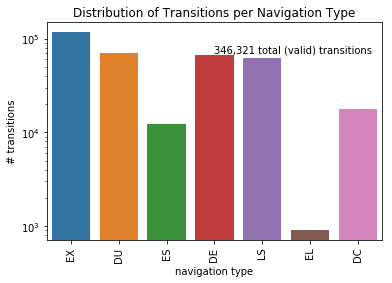

In [62]:
tmp = {}
tmp['navitype'] = NAVITYPES
tmp['ntransitions'] = [transitions[navitype] for navitype in NAVITYPES]
tmp = pd.DataFrame(tmp)
ax = sns.barplot(x='navitype',y='ntransitions',
                   data=tmp,
                   order=valid_clickstreams['_navitype'].value_counts().index)
                   #order=tmp.sort_values('ntransitions', ascending=False)['navitype'])
ax.set_yscale('log')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Distribution of Transitions per Navigation Type')
_ = ax.set_ylabel('# transitions')
_ = ax.set_xlabel('navigation type')
try:
    id=3
    ax.text(id, tmp.loc[id,'ntransitions'], '{:,} total (valid) transitions'.format(int(transitions[None])))
except:
    pass

In [73]:
%%capture cap --no-stderr
columns = ['ontology','navitype','ntransitions']
df = pd.DataFrame(columns=columns)

for navitype in NAVITYPES:
    for onto_name in valid_ontologies_clickstream._ontology.unique():
        try:
            # all transitions
            cs = Transition(onto_name, navitype, YEAR)            
            cs.load_graph(path=TRANS_GRAPH_OUTPUT)
            
            df = df.append({'ontology':onto_name,
                            'navitype':navitype,
                            'ntransitions':cs.H.size(weight='weight')}, ignore_index=True)
            del(cs)
        except Exception as ex:
            print(ex)

In [74]:
print(cap.stdout)
log(LOG_OUTPUT, ON, cap)
del(cap)

2018-11-12 11:54:30	/bigdata/lespin/bioportal/transitions/graph/SNOMEDCT_2015_DC.gpickle loaded!
2018-11-12 11:54:30	/bigdata/lespin/bioportal/transitions/graph/CPT_2015_DC.gpickle loaded!
2018-11-12 11:54:30	/bigdata/lespin/bioportal/transitions/graph/ICD10_2015_DC.gpickle loaded!
2018-11-12 11:54:30	/bigdata/lespin/bioportal/transitions/graph/RXNORM_2015_DC.gpickle loaded!
2018-11-12 11:54:30	/bigdata/lespin/bioportal/transitions/graph/RCD_2015_DC.gpickle loaded!
2018-11-12 11:54:30	[Errno 2] No such file or directory: '/bigdata/lespin/bioportal/transitions/graph/STY_2015_DC.gpickle'
2018-11-12 11:54:30	ERROR: /bigdata/lespin/bioportal/transitions/graph/STY_2015_DC.gpickle NOT loaded!
'NoneType' object has no attribute 'size'
2018-11-12 11:54:30	[Errno 2] No such file or directory: '/bigdata/lespin/bioportal/transitions/graph/RADLEX_2015_DC.gpickle'
2018-11-12 11:54:30	ERROR: /bigdata/lespin/bioportal/transitions/graph/RADLEX_2015_DC.gpickle NOT loaded!
'NoneType' object has no attri

In [82]:
df.head()

,ontology,navitype,ntransitions
0,SNOMEDCT,DC,5294.0
1,CPT,DC,5220.0
2,ICD10,DC,571.0
3,RXNORM,DC,42.0
4,RCD,DC,57.0


In [90]:
sorted_ontos = df.groupby('ontology').ntransitions.sum().reset_index()
sorted_ontos.sort_values('ntransitions', ascending=False, inplace=True)
sorted_ontos

,ontology,ntransitions
18,SNOMEDCT,112522.0
10,MEDDRA,71269.0
2,CPT,43778.0
16,RXNORM,29180.0
14,OMIM,27472.0
13,NDFRT,24733.0
8,LOINC,8206.0
17,SNMI,6092.0
6,ICD9CM,4621.0
11,MESH,3896.0


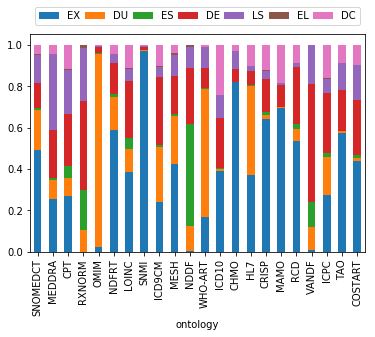

In [106]:
tmp = df.pivot(columns='ontology',index='navitype',values='ntransitions').fillna(0).reindex(index = valid_clickstreams['_navitype'].value_counts().index)[sorted_ontos.ontology]
ax = tmp.divide(tmp.sum(axis=0),axis=1).T.plot.bar(stacked=True, linewidth=0.0)
_ = ax.legend(loc='best', mode='expand', ncol=7, bbox_to_anchor=(0.0, 0.15, 1.0, 1.0))
